# Vorbereitung der Studie
Im Folgenden wird der Review-Datensatz eingelesen, das KI-Modell trainiert und anschließend die Regression für die Transformation der Confidence-Werte in Wahrscheinlichkeits-Werte durchgeführt. Die folgenden Überschriften und Texte sind identisch mit dem Abschnitt 3.1 Vorbereitung des Datensatzes.

## 3.1.1 Datengrundlage (Review-Datensatz)
Der Datensatz ist unterteilt in einen Trainings- und einen Testdatensatz mit jeweils 25.000 Reviews. Diese sind weiter gleichmäßig aufgeteilt in positive und negative Reviews. Positive Reviews wurden dabei mit mindestens 7 von 10 Sternen bewertet, negative mit maximal 4. Neutralere Bewertungen von 5 oder 6 Sternen kommen nicht vor.

Um den Datensatz in drei gleiche Teile zu trennen, wurden zunächst alle 50.000 Reviews eingelesen und anschließend in drei Datensätze unterteilt: Der erste Datensatz „train“ dient lediglich dazu, das KI-Modell zu trainieren, der zweite Datensatz „reg“ dient der Transformation der Confidence-Werte mithilfe einer Regression und der dritte Datensatz „test“ stellt den Testdatensatz zur Überprüfung des KI-Modells sowie der Regression dar. Außerdem dient dieser als Pool für die Ziehung der Reviews für die Studie.


In [1]:
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# Der Datensatz ist das Large Movie Review Dataset v1.0 nach "Learning Word Vectors for Sentiment Analysis" von Maas et al., 2011. (http://www.aclweb.org/anthology/P11-1015) Dieses muss heruntergeladen und das gleiche Verzeichnis extrahiert werden. (Heruntergeladen am 08.08.2023 von https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz)
DATADIR = "aclImdb"
random_state = 42
np.random.seed(random_state)

features = 'review'
label = 'rating_binary'

def load_data(path = DATADIR):
    reviews = []
    for train_test_split in ['train', 'test']:
        for label in ['pos','neg']:
            for file in glob.glob(os.path.join(DATADIR, train_test_split, label, '*.txt')):
                reviews.append({
                    'review': open(file, encoding='utf-8').read(),
                    'rating_binary': label,
                    'rating': int(file.split("/")[-1].split('_')[1].split(".")[0]),
                })
    return pd.DataFrame(reviews)

df = load_data()

# Die Texte der Reviews sind im Datensatz als HTML-Strings enthalten und werden nun in den Roh-Text überführt.
df[features] = df[features].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())

print(df)

# Der Datensatz wird in drei gleich große Teile aufgeteilt und die Indizes zurückgesetzt.
# Die drei Datensätze sind:
# - train_df: Dient rein dem trainieren der des "linear unigram bag-of-words classifier"
# - reg_df: Dient der Regression umd die Confidence-Werte in Wahrscheinlichkeitswerte überführen zu können
# - test_df: Dient als Testdatensatz zur Berechnung der Performance des Modells und der Regression sowie als Pool für die Reviews für die Studie.
train_df, temp = train_test_split(df, test_size=2/3, random_state=random_state)
reg_df, test_df = train_test_split(temp, test_size=0.5, random_state=random_state)
train_df.index = range(len(train_df))
reg_df.index = range(len(reg_df))
test_df.index = range(len(test_df))

len(train_df), len(reg_df), len(test_df)


/var/folders/1l/png2w8ss4qx8b3pr31666ccw0000gn/T/ipykernel_89944/2824048233.py:36: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  df[features] = df[features].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())


                                                  review rating_binary  rating
0      For a movie that gets no respect there sure ar...           pos       9
1      Bizarre horror movie filled with famous faces ...           pos       8
2      A solid, if unremarkable film. Matthau, as Ein...           pos       7
3      It's a strange feeling to sit alone in a theat...           pos       8
4      You probably all already know this by now, but...           pos      10
...                                                  ...           ...     ...
49995  With actors like Depardieu and Richard it is r...           neg       1
49996  If you like to get a couple of fleeting glimps...           neg       1
49997  When something can be anything you want it to ...           neg       1
49998  I had heard good things about "States of Grace...           neg       3
49999  Well, this movie actually did have one redeemi...           neg       1

[50000 rows x 3 columns]
Länge der Datensätze:
1666

(16666, 16667, 16667)

## 3.1.2 Machine Learning Model
Für die Bereitstellung von KI-Ergebnissen wurde ein KI-Modell mithilfe des Trainingsdatensatzes „train“ trainiert. Das Training fand gemäß den Ergebnissen von Schmidt und Biessmann aus dem Jahr 2019 statt. Die Einstellungen für das Training des Modells wurden aus dem zugehörigen GitHub repository übernommen. Auf die Berechnung der zusätzlichen Erklärungen wurde verzichtet.

Das trainierte Modell wurde anschließend mithilfe der Datensätze „reg“ und „test“ getestet und hatte jeweils eine Genauigkeit von circa 88%. Vorherige Ergebnisse, die die Genauigkeit von Probanden auf exakt diesem Datensatz untersuchten, kamen auf Werte zwischen 75 und 80% .

In [3]:
# Es wird ein "linear unigram bag-of-words classifier" mithilfe des Datensatzes 'train_df' trainiert und auf die Datensätze 'reg_df' und 'test_df' angewendet.
# Die Einstellungen dafür wurden übernommen aus "Transparency and trust in artificial intelligence systems" von Schmidt et al., 2020. (https://www.tandfonline.com/doi/full/10.1080/12460125.2020.1819094)
vect = TfidfVectorizer(stop_words=list(ENGLISH_STOP_WORDS)).fit(train_df[features])
X_train = vect.transform(train_df[features])
X_reg = vect.transform(reg_df[features])
X_test = vect.transform(test_df[features])

clf = SGDClassifier(loss='log_loss', 
                    n_jobs=-1, 
                    random_state=random_state,
                    alpha=0.0001
                   ).fit(X_train, train_df[label])

# Das Modell wird jeweils auf 'reg_df' sowie 'test_df' angewendet.
# 'predictions' entspricht der Vorhersage des Modells ('pos' oder 'neg')
# 'prediction_proba_max' entspricht dem Confidence-Wert der Vorhersage (Wert zwischen 0.5 und 1)
reg_df['predictions'] = clf.predict(X_reg)
predictions_proba = clf.predict_proba(X_reg)
reg_df['prediction_proba_max'] = predictions_proba.max(axis=1)

test_df['predictions'] = clf.predict(X_test)
predictions_proba = clf.predict_proba(X_test)
test_df['prediction_proba_max'] = predictions_proba.max(axis=1)

# Ausgabe der Ergebnisse des Modells auf den Datensätzen reg_df und test_df
# Dabei sollten die Ergebnisse für beide Datensätze ungefähr gleich sein. Der Anteil positiver Reviews sollte ungefähr bei 0.5 liegen (gleich dem ursprünglichen Datensatz).
print("\nREG (reg_df)")
print(classification_report(reg_df[label], reg_df['predictions']))
print(f"Durchschnittlicher Confidence-Wert: {reg_df['prediction_proba_max'].mean()}")
print(f"Performance: {(reg_df['predictions'] == reg_df['rating_binary']).mean()}")
print(f"Anteil positiver Reviews: {(reg_df['rating_binary'] == 'pos').sum() / len(reg_df) * 100}")

print("\nTEST (test_df)")
print(classification_report(test_df[label], test_df['predictions']))
print(f"Durchschnittlicher Confidence-Wert: {test_df['prediction_proba_max'].mean()}")
print(f"Performance: {(test_df['predictions'] == test_df['rating_binary']).mean()}")
print(f"Anteil positiver Reviews: {(test_df['rating_binary'] == 'pos').sum() / len(test_df) * 100}")


REG (reg_df)
              precision    recall  f1-score   support

         neg       0.89      0.86      0.88      8265
         pos       0.87      0.89      0.88      8402

    accuracy                           0.88     16667
   macro avg       0.88      0.88      0.88     16667
weighted avg       0.88      0.88      0.88     16667

Durchschnittlicher Confidence-Wert: 0.7432366259001072
Performance: 0.878082438351233
Anteil positiver Reviews: 50.410991780164395

TEST (test_df)
              precision    recall  f1-score   support

         neg       0.89      0.86      0.88      8372
         pos       0.86      0.89      0.88      8295

    accuracy                           0.88     16667
   macro avg       0.88      0.88      0.88     16667
weighted avg       0.88      0.88      0.88     16667

Durchschnittlicher Confidence-Wert: 0.7437602170619964
Performance: 0.877002459950801
Anteil positiver Reviews: 49.769004619907605


## 3.1.3 Transformation der Confidence-Werte
Die Ergebnisse aus dem KI-Modell bestehen aus zwei Werten, die jeweils den Confidence-Wert für die Möglichkeiten „negativ“ und „positiv“ darstellen. Beide Werte ergeben zusammen 1.0. Die Option (positiv/negativ) mit dem höheren Wert wird die Vorhersage des Modells mit dem dazugehörigen Confidence-Wert. Somit liegen die Confidence-Werte für die von der KI getippten Ergebnisse stets zwischen 0.5 und 1.0. Anders als diese Zahlen vermuten lassen, stellen diese Werte jedoch nicht die Wahrscheinlichkeiten für ein richtiges Ergebnis dar. Dies wird deutlich, wenn man das Modell auf die anderen beiden Datensätze anwendet. Während die Genauigkeit der KI bei circa 88% Prozent liegt, ist der durchschnittliche Confidence-Wert gerade einmal ungefähr 0.74. Da die Confidence-Werte für Menschen somit nicht intuitiv zu verstehen sind, wurden diese in Wahrscheinlichkeits-Werte transformiert.

Dazu wurde zunächst das Modell auf den Datensatz „reg“ angewendet und die KI-Ergebnisse sowie die Confidence-Werte berechnet. Um einen breiteren Datensatz zu erhalten wurden anschließend zu jedem Ergebnis die Inverse berechnet und hinzugefügt. Die Inverse stellt dabei jeweils das KI-Ergebnis für die andere Möglichkeit dar. In dem Fall, dass die KI richtig liegt mit einem Confidence-Wert von 0.8, würde die Inverse also lauten, dass die KI falsch liegt mit einem Confidence-Wert von 0.2. Dadurch konnte der Bereich der Confidence-Werte auf 0 bis 1 verbreitert werden. Insgesamt gingen somit 33334 KI-Ergebnisse in die Berechnung ein. Um den Zusammenhang der Genauigkeit (Performance) und der Confidence-Werte berechnen zu können, wurden Confidence-Intervalle gebildet, die jeweils die KI-Ergebnisse zwischen zwei Confidence-Grenzwerten beinhalteten. Die Breite der Intervalle wurde dabei auf 0.01 festgelegt, wodurch sich 100 Intervalle mit durchschnittlich 333 KI-Ergebnissen ergeben. Für jedes Intervall wurden anschließend die Performance (Anteil der richtigen KI-Ergebnisse) sowie der durchschnittliche Confidence-Wert berechnet.

In [4]:
def getIntervals (df):
    new_rows = []
    for index, row in df.iterrows():
        new_rows.append({
            **row,
            'predictions': 'pos' if row['predictions'] == 'neg' else 'neg',
            'prediction_proba_max': 1 - row['prediction_proba_max'],
        })
    inverse_df = pd.DataFrame(new_rows)
    full_range_df = pd.concat([df, inverse_df])

    # Anschließend werden die Intervalle gebildet und die Performance berechnet. Die Intervall-Länge beträgt 0.01, was bei Confidence-Werten von 0 bis 1 exakt 100 Intervalle ergibt.
    cw_intervals = []
    i = 0.0
    while i < 1.0:
        i = round(i, 2)
        min = i
        max = round(i + 0.01, 2)
        # Das gesamte Dataframe wird auf das jeweilige Confidence-Intervall gefiltert.
        filtered_df = full_range_df.loc[(full_range_df['prediction_proba_max'] >= min) & (full_range_df['prediction_proba_max'] < max)]
        # Über alle in dem Intervall enthaltene Datenpunkte werden die durchschnittliche Performance und Confidence-Werte berechnet.
        # Zusätzlich wird abgespeichert wie viele Datenpunkte in dem jeweiligen Intervall enthalten sind.
        performance_mean = (filtered_df['predictions'] == filtered_df['rating_binary']).mean()
        prediction_mean = filtered_df['prediction_proba_max'].mean()
        cw_intervals.append({
            'performance': performance_mean,
            'prediction': prediction_mean,
            'n': len(filtered_df)
        })
        i += 0.01
    
    return pd.DataFrame(cw_intervals)

# Berechnenen (und abspeichern) der Intervalle für reg_df und test_df
reg_interval_df = getIntervals(reg_df)
test_interval_df = getIntervals(test_df)

reg_interval_df

,performance,prediction,n
0,0.015385,0.006538,65
1,0.000000,0.015433,174
2,0.010695,0.025079,187
3,0.000000,0.035077,202
4,0.004082,0.045007,245
...,...,...,...
95,0.995918,0.954993,245
96,1.000000,0.964923,202
97,0.989305,0.974921,187
98,1.000000,0.984567,174


Anhand dieser 100 Datenpunkte wurde eine logistische Regression durchgeführt. Wie anhand der Abbildung 2 gut zu erkennen ist, eignet sich die logistische Regressionsfunktion sehr gut dazu den Zusammenhang von Performance und Confidence-Werten zu berechnen. Das Bestimmtheitsmaß R2 liegt bei 0.998 (angepasst 0.998). Die Güte der Regression ist also als sehr hoch zu bewerten. Eine lineare Regression mit R2=0.938 war entsprechend deutlich unterlegen.
Die berechnete Regressionsfunktion wurde auf den Datensatz „test“ angewendet um die Confidence-Werte in Wahrscheinlichkeits-Werte umzuwandeln.


Lineare Regression
reg_interval_df R2: 0.938456861645218


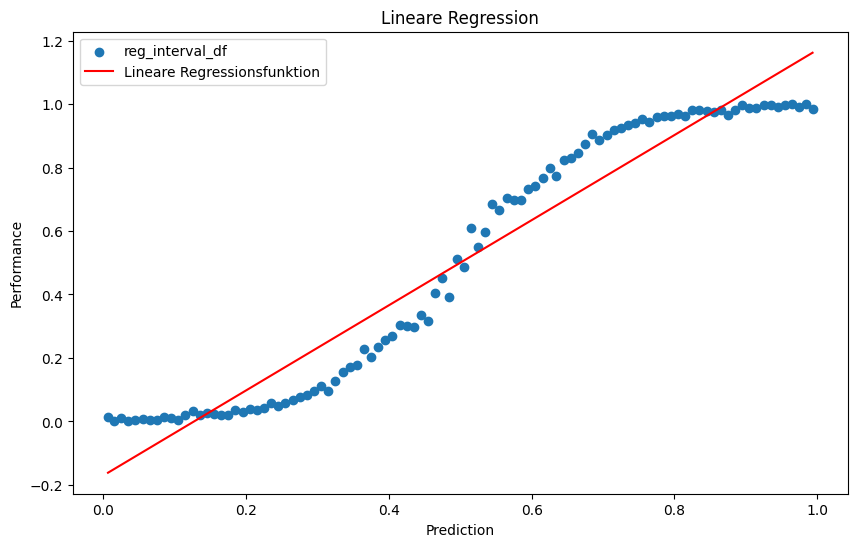

In [9]:
# Die lineare Regression zeigt mit R2-Werten zwischen 0.93 und 0.94 gute Ergebnisse. Sieht man sich allerdings das Diagramm an, so ist erkennbar, dass die Verteilung stark einer logistischen Funktion ähnelt. Somit wird anschließend eine zweite - logistische - Regression durchgeführt.
# Definition der linearen Funktion
def linear(x, m, b):
    return m * x + b
x = reg_interval_df['prediction'].values
y = reg_interval_df['performance'].values
popt, pcov = curve_fit(linear, x, y)
m, b = popt
x_fit = np.linspace(min(x), max(x), 1000)
y_fit = linear(x_fit, m, b)
y_pred = linear(x, m, b)
r2 = r2_score(y, y_pred)
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='reg_interval_df')
plt.plot(x_fit, y_fit, 'r', label='Lineare Regressionsfunktion')
plt.xlabel('Prediction')
plt.ylabel('Performance')
plt.title(f'Lineare Regression')
print("Lineare Regression")
print(f'reg_interval_df R2: {r2}')
plt.legend()
plt.show()

Logistische Regression
reg_interval_df R2: 0.9979985874988517
adjusted reg_interval_df R2: 0.9979781649223094
test_interval_df R2: 0.9980559651764355


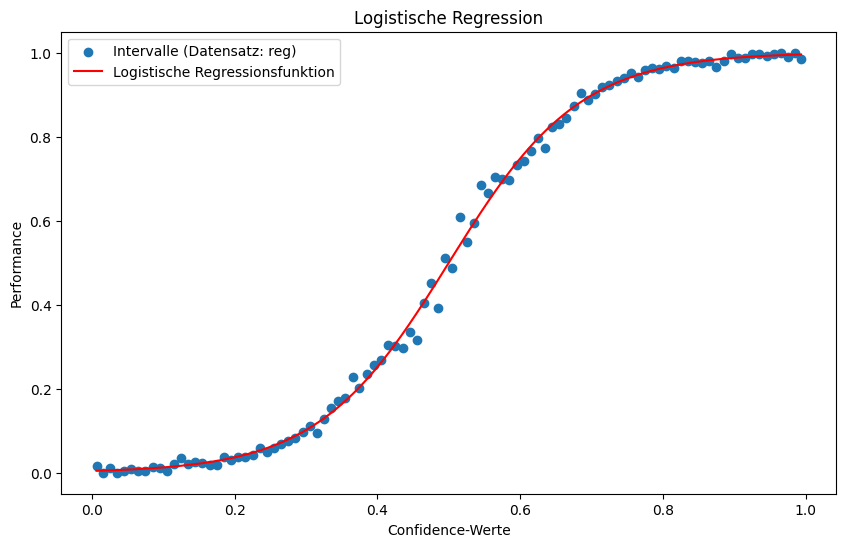

In [10]:
# Wie erwartet zeigt die logistische Regression deutlich bessere Ergebnisse mit R2-Werten von klar über 0.99.
# Somit dient die logistische Regression bzw. die Ergebnisse dieser als Instrument zur Transformation der Confidence-Werte in Wahrscheinlichkeits-Werte.
# Definition der logistischen Funktion
def logistic(x, L, k, x0):
    return L / (1 + np.exp(-k*(x-x0)))
x = reg_interval_df['prediction'].values
y = reg_interval_df['performance'].values
popt, pcov = curve_fit(logistic, x, y, p0=[max(y), 1, np.median(x)])
L, k, x0 = popt
x_fit = np.linspace(min(x), max(x), 1000)
y_fit = logistic(x_fit, L, k, x0)
y_pred = logistic(x, L, k, x0)
r2 = r2_score(y, y_pred)
adjusted_r2 = 1 - (1 - r2) * (len(y) - 1) / (len(y) - 1 - 1)
x_test = test_interval_df['prediction'].values
y_test = test_interval_df['performance'].values
y_test_pred = logistic(x_test, L, k, x0)
r2_test = r2_score(y_test, y_test_pred)
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label=f'Intervalle (Datensatz: reg)')
plt.plot(x_fit, y_fit, 'r', label=f'Logistische Regressionsfunktion')
plt.xlabel('Confidence-Werte')
plt.ylabel('Performance')
plt.title('Logistische Regression')
plt.legend()
plt.savefig('figures/regression_logistic.png', dpi=3000)
print("Logistische Regression")
print(f'reg_interval_df R2: {r2}')
print(f'adjusted reg_interval_df R2: {adjusted_r2}')
print(f'test_interval_df R2: {r2_test}')
plt.show()

## 3.1.4 Auswahl der Reviews
Für die Studie wurden aus dem Datensatz „test“ 20 Reviews ausgewählt, die später von den Probanden klassifiziert werden sollten. Dazu wurden zufällig jeweils 10 positive und negative Reviews ausgewählt. Von den 20 Reviews lag das KI-Modell in 17 Fällen richtig, was einer repräsentativen Performance von 85% entspricht. Somit liegt die Performance der KI-Ergebnisse über der erwarteten Performance der menschlichen Probanden (siehe 3.1.2).

In [11]:
# Die Confidence-Werte des test_df Dataframes werden mithilfe der logistischen Regressionsfunktion in Wahrscheinlichkeits-Werte transformiert und als neue Spalte gespeichert.
test_df['probability_value'] = test_df['prediction_proba_max'].apply(lambda cw: logistic(cw, L, k, x0))
# Auswahl der Stichprobe mit gleicher Anzahl von positiven und negativen Reviews (jeweils 10 Reviews)
pos_sample = test_df[test_df[label] == 'pos'].sample(n=10, random_state=random_state)
neg_sample = test_df[test_df[label] == 'neg'].sample(n=10, random_state=random_state)
sample = pd.concat([pos_sample, neg_sample], axis=0).reset_index(drop=True)
sample.to_csv('review_samples/sample_df.csv', index=False)

# Ausgabe der Performance-Werte für die Stichprobe
print("Stichprobe für die Studie" )
print(classification_report(sample[label], sample['predictions']))
# Stichprobe formatieren für den Import in den Fragebogen
formatted_data = sample.apply(lambda row: f"{row.name};{row.name};{row['review'].replace(';', ',')};{row['rating_binary'].replace('pos', 'positive').replace('neg', 'negative')};{row['predictions'].replace('pos', 'positive').replace('neg', 'negative')};{round(row['prediction_proba_max'], 2)};{int(round(row['probability_value'], 2)*100)}%;1", axis=1)
# Stichprobe in eine Datei schreiben um diese in EFS Survey importieren zu können (als statische Liste)
with open("review_samples/sample_unipark.txt", "w") as file:
    for entry in formatted_data:
        file.write(entry + "\n")

Stichprobe für die Studie
              precision    recall  f1-score   support

         neg       0.89      0.80      0.84        10
         pos       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20

